In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from wordcloud import WordCloud

In [4]:
train_df = pd.read_csv("C:/Users/naure/OneDrive/Desktop/codsoft/movie genre classification/Genre Classification Dataset/train_data.txt", sep=' ::: ', engine='python', header=None,
                       names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])
test_df = pd.read_csv("C:/Users/naure/OneDrive/Desktop/codsoft/movie genre classification/Genre Classification Dataset/test_data.txt", sep=' ::: ', engine='python', header=None,
                      names=['ID', 'TITLE', 'DESCRIPTION'])

In [5]:
print(train_df.head())
print(train_df['GENRE'].value_counts())

   ID                             TITLE     GENRE  \
0   1      Oscar et la dame rose (2009)     drama   
1   2                      Cupid (1997)  thriller   
2   3  Young, Wild and Wonderful (1980)     adult   
3   4             The Secret Sin (1915)     drama   
4   5            The Unrecovered (2007)     drama   

                                         DESCRIPTION  
0  Listening in to a conversation between his doc...  
1  A brother and sister with a past incestuous re...  
2  As the bus empties the students for their fiel...  
3  To help their unemployed father make ends meet...  
4  The film's title refers not only to the un-rec...  
GENRE
drama          13613
documentary    13096
comedy          7447
short           5073
horror          2204
thriller        1591
action          1315
western         1032
reality-tv       884
family           784
adventure        775
music            731
romance          672
sci-fi           647
adult            590
crime            505
animation

In [27]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

ID             0
TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64
ID             0
TITLE          0
DESCRIPTION    0
dtype: int64


In [28]:
# ----------- 1. LOAD AND BASIC CLEANING -----------
def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)         # remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)      # remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text)          # remove extra whitespace
    return text.strip()

In [29]:
# Drop rows with missing values in train
train_df.dropna(subset=['GENRE', 'DESCRIPTION', 'TITLE'], inplace=True)
test_df.dropna(subset=['DESCRIPTION', 'TITLE'], inplace=True)

In [16]:
# Clean text
train_df['DESCRIPTION'] = train_df['DESCRIPTION'].apply(clean_text)
train_df['TITLE'] = train_df['TITLE'].apply(clean_text)
test_df['DESCRIPTION'] = test_df['DESCRIPTION'].apply(clean_text)
test_df['TITLE'] = test_df['TITLE'].apply(clean_text)

In [30]:
# Combine TITLE and DESCRIPTION
train_df['TEXT'] = train_df['TITLE'] + " " + train_df['DESCRIPTION']
test_df['TEXT'] = test_df['TITLE'] + " " + test_df['DESCRIPTION']


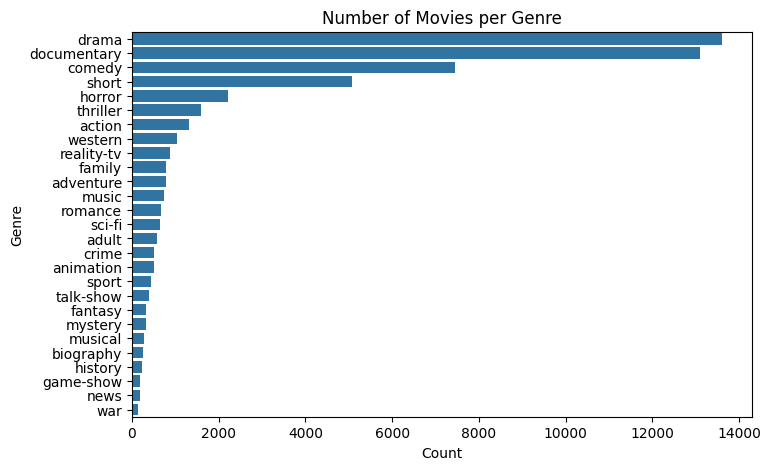

In [31]:
# Genre distribution
plt.figure(figsize=(8,5))
sns.countplot(y=train_df['GENRE'], order=train_df['GENRE'].value_counts().index)
plt.title('Number of Movies per Genre')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

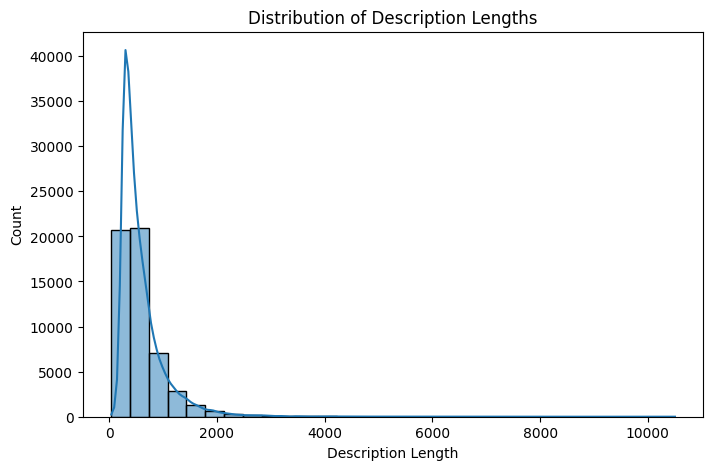

In [32]:
# Description length distribution
train_df['desc_length'] = train_df['DESCRIPTION'].str.len()
plt.figure(figsize=(8,5))
sns.histplot(train_df['desc_length'], bins=30, kde=True)
plt.title('Distribution of Description Lengths')
plt.xlabel('Description Length')
plt.show()

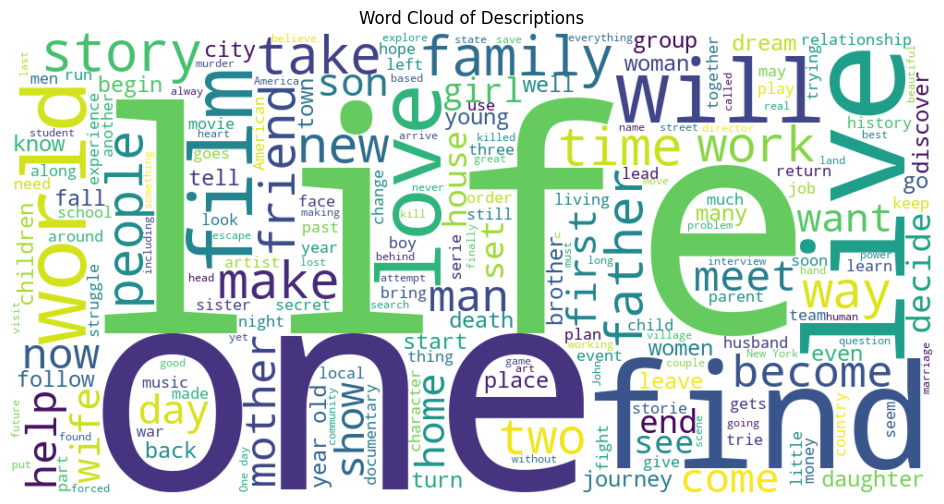

In [33]:
# Word Cloud of Descriptions
plt.figure(figsize=(12,6))
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(' '.join(train_df['DESCRIPTION'].dropna()))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Descriptions')
plt.show()

In [34]:

vectorizer = TfidfVectorizer(stop_words='english', max_features=8000, ngram_range=(1,2))
X = vectorizer.fit_transform(train_df['TEXT'])
y = train_df['GENRE']
class_names = np.unique(y)

# Split train/val for better evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ----------- 4. MODEL SELECTION & HYPERPARAM TUNING -----------

# Try Logistic Regression with GridSearchCV for best results
param_grid = {
    'C': [0.1, 1, 5, 10],
    'solver': ['liblinear', 'lbfgs']
}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)
model = grid.best_estimator_
print(f"Best Logistic Regression Params: {grid.best_params_}")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Logistic Regression Params: {'C': 5, 'solver': 'liblinear'}


In [35]:
y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=class_names))


Validation Accuracy: 0.5900
Classification Report:


C:\Users\naure\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naure\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naure\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

      action       0.50      0.35      0.41       263
       adult       0.74      0.34      0.47       118
   adventure       0.51      0.19      0.27       155
   animation       0.46      0.18      0.26       100
   biography       0.00      0.00      0.00        53
      comedy       0.53      0.59      0.56      1490
       crime       0.33      0.05      0.09       101
 documentary       0.68      0.84      0.75      2619
       drama       0.57      0.74      0.64      2723
      family       0.42      0.14      0.21       157
     fantasy       0.25      0.03      0.05        65
   game-show       0.95      0.51      0.67        39
     history       0.50      0.02      0.04        49
      horror       0.68      0.63      0.66       441
       music       0.67      0.45      0.53       146
     musical       0.30      0.05      0.09        55
     mystery       0.60      0.05      0.09        64
        news       0.38    